In [ ]:
## Enviroment Setup
import os, sys
WORKING_DIR = '/home/peizhi/Documents/gmesh'
os.chdir(WORKING_DIR) # change the working directory to the project's absolute path
print("Current Working Directory: ", os.getcwd())

## Computing Device
device = 'cuda:0'
import torch
torch.cuda.set_device(device) # this will solve the problem that OpenGL not on the same device with torch tensors

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

import utils.o3d_utils as o3d_utils
from utils.mesh2gaussians_utils import mesh_to_gaussians
from scenes.mesh import Mesh
from scenes.gaussians import Gaussians
from scenes.cameras import PerspectiveCamera
from renderer.rasterizer_gsplat import GaussianRasterizer


Current Working Directory:  /home/peizhi/Documents/gmesh
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Mesh(Vertices=2930, Faces=5856)
Gaussians(N=2930, SH Degrees=0, means=torch.Size([2930, 3]), quats=torch.Size([2930, 4]), scales=torch.Size([2930, 3]), opacities=torch.Size([2930]), colors=torch.Size([2930, 1, 3]))


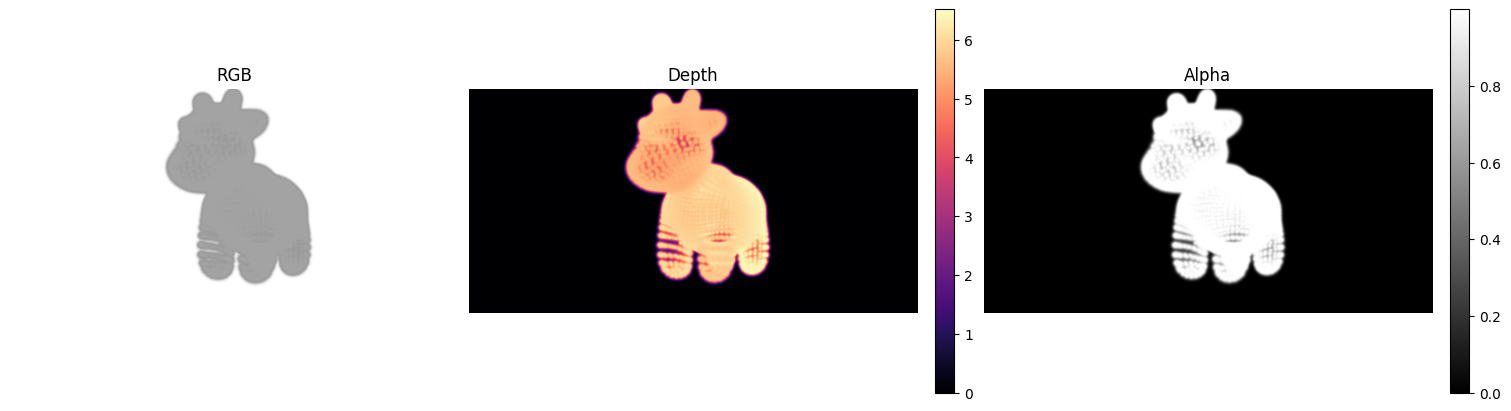

In [2]:

# load an example mesh
vertices, faces = o3d_utils._read_obj_file('./assets/data/spot.obj', uv=False)

# rotate the mesh along the y axis (yaw)
theta = np.pi * 0.8
rotation_matrix = torch.tensor([
    [np.cos(theta), 0, np.sin(theta)],
    [0, 1, 0],
    [-np.sin(theta), 0, np.cos(theta)]
], dtype=torch.float32, device=device)

# convert from numpy arrays to tensors
vertices = torch.from_numpy(vertices).float().to(device) @ rotation_matrix.T  # [V, 3]
faces = torch.from_numpy(faces).to(device) # [F, 3]

# create to Mesh object
mesh = Mesh(verts=vertices, faces=faces)
print(mesh)

# convert mesh to 3D Gaussians objcet
gaussians = mesh_to_gaussians(mesh=mesh, method='vertex', trainable=False)
print(gaussians)

# create the camera
camera = PerspectiveCamera(
    image_width=1024, image_height=512, fov_x=40, fov_y=20, z_near=0.1, z_far=100, device=device
)

# create the 3DGS rasterizer
gaussian_rasterizer = GaussianRasterizer(camera=camera)

# set camera pose (yaw, pitch, roll, dx, dy, dz)
camera_pose = torch.tensor([[0,0,0,0,0,6.0]]).float().to(device)

# render the 3D Gaussians
rgb, depth, alpha = gaussian_rasterizer.rasterize(gaussians=gaussians, camera_pose=camera_pose)


# visualize the rendering
rgb = np.clip(rgb.detach().cpu(), 0.0, 1.0)
depth = depth.detach().cpu()
alpha = alpha.detach().cpu()

fig, axes = plt.subplots(1, 3, figsize=(15,4), constrained_layout=True)

axes[0].imshow(rgb[0,...])
axes[0].set_title('RGB')
axes[0].axis('off')

im1 = axes[1].imshow(depth[0,...,0], cmap='magma')
axes[1].set_title('Depth')
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(alpha[0,...,0], cmap='gray')
axes[2].set_title('Alpha')
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.show()
